# Feature Selection using Random Forest

- Initially considered LightGBM / XGBoost but ran into some dependency issues on M1 Mac so pivoted to RF

In [30]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import sys
import os
from sklearn.feature_selection import SelectFromModel
from andy.model import (
    create_model_pipeline,
    optimize_hyperparameters,
    select_features,
    explain_with_shap,
    final_modeling_pipeline,
    map_eda_to_ohe,
    evaluate_features_by_count,
)
from andy.category import (
    CategoricalTransformer,
    OrdinalTransformer,
    AddressTransformer,
    JobTitleTransformer,
    PurposeTransformer,
)
from andy.params import (
    EMP_LENGTH_RANKS,
    HOME_OWNERSHIP_RANKS,
    JOB_MAP,
    VERIFICATION_STATUS_RANKS,
)
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_recall_curve,
    auc,
    classification_report
)
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath("../src"))

# 1. Prepare Data
train = pd.read_parquet("../data/train_cleaned.parquet")
X = train.drop(columns=['loan_status', 'is_default']).copy()

# Apply transformations that might drop rows
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna(axis=0, how='any')  # or however you're cleaning

# Now extract target AFTER row drops
y = train.loc[X.index, 'is_default']

# Fix 'term' column format: e.g., ' 36 months' -> 36
if 'term' in X.columns:
    X['term'] = X['term'].str.extract(r'(\d+)').astype(float)

# Drop fully null or constant columns
X = X.dropna(axis=1, how='all')
X = X.loc[:, X.nunique() > 1]

# Remove inf and -inf, replace with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows (or columns) with all NaNs if needed
X = X.dropna(axis=0, how='any')  # safer: drop rows with any NaNs

# 2. Apply Custom Transformers
ordinal_mapping = {
    'grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    'emp_length': [
        '< 1 year', '1 year', '2 years', '3 years', '4 years',
        '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'
    ],
    'home_ownership': ['OWN', 'MORTGAGE', 'RENT', 'OTHER']
}

ordinal = OrdinalTransformer(ordinal_mapping)
purpose = PurposeTransformer()
categorical = CategoricalTransformer(categorical_cols=X.select_dtypes(include='object').columns.tolist())

for transformer in [ordinal, purpose, categorical]:
    X = transformer.fit_transform(X)

# 3. Column Transformers
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# 4. Transform Data
X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# 5. Train Random Forest and Select Important Features
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_processed, y)

# Use median importance as threshold to keep top half
selector = SelectFromModel(rf, threshold="median", prefit=True)
X_selected = selector.transform(X_processed)

selected_features = feature_names[selector.get_support()]

print(f"✅ Top {len(selected_features)} features selected:")
print(selected_features)

✅ Top 89 features selected:
['num__loan_amnt' 'num__term' 'num__int_rate' 'num__installment'
 'num__annual_inc' 'num__dti' 'num__open_acc' 'num__pub_rec'
 'num__revol_bal' 'num__revol_util' 'num__total_acc' 'num__mort_acc'
 'num__pub_rec_bankruptcies' 'num__loan_to_income' 'cat__grade_A'
 'cat__grade_B' 'cat__grade_C' 'cat__grade_D' 'cat__grade_E'
 'cat__grade_F' 'cat__sub_grade_A1' 'cat__sub_grade_A5'
 'cat__sub_grade_B1' 'cat__sub_grade_B2' 'cat__sub_grade_B4'
 'cat__sub_grade_C1' 'cat__sub_grade_C2' 'cat__sub_grade_C3'
 'cat__sub_grade_C4' 'cat__sub_grade_C5' 'cat__emp_length_1 year'
 'cat__emp_length_10+ years' 'cat__emp_length_2 years'
 'cat__emp_length_3 years' 'cat__emp_length_4 years'
 'cat__emp_length_5 years' 'cat__emp_length_6 years'
 'cat__emp_length_7 years' 'cat__emp_length_8 years'
 'cat__emp_length_9 years' 'cat__emp_length_< 1 year'
 'cat__home_ownership_MORTGAGE' 'cat__home_ownership_OWN'
 'cat__home_ownership_RENT' 'cat__verification_status_Not Verified'
 'cat__verif

# Use Optuna to Tune Random Forest Hyperparams 

In [ ]:
best_params = optimize_hyperparameters(X, y, preprocessor, n_trials=10)

[I 2025-04-01 00:09:54,723] A new study created in memory with name: no-name-05dde772-f894-432d-a2e8-20ca306eb7a0
[I 2025-04-01 00:10:33,434] Trial 0 finished with value: 0.7141676886297997 and parameters: {'n_estimators': 81, 'max_depth': 11, 'min_samples_split': 4}. Best is trial 0 with value: 0.7141676886297997.
[I 2025-04-01 00:11:24,765] Trial 1 finished with value: 0.7080324963965525 and parameters: {'n_estimators': 208, 'max_depth': 4, 'min_samples_split': 2}. Best is trial 0 with value: 0.7141676886297997.
[I 2025-04-01 00:11:55,524] Trial 2 finished with value: 0.7082717227989054 and parameters: {'n_estimators': 88, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 0 with value: 0.7141676886297997.
[I 2025-04-01 00:14:17,597] Trial 3 finished with value: 0.7162419105728635 and parameters: {'n_estimators': 240, 'max_depth': 14, 'min_samples_split': 7}. Best is trial 3 with value: 0.7162419105728635.
[I 2025-04-01 00:15:12,146] Trial 4 finished with value: 0.710058677640451

# Cominbation of the features & Choosing the features

In [ ]:
# Combining and getting the features down to the most important ones 
# Features from EDA, Random Forest have all been utilized 

# Features chosen from EDA 
eda_features = [
    'num__loan_to_income', 
    'num__dti',
    'cat__purpose_credit_card', 'cat__purpose_debt_consolidation',
    'cat__verification_status_Not Verified',
    'cat__verification_status_Source Verified',
    'cat__verification_status_Verified'
]

# Combine all sources
combined_features = list(set(eda_features + selected_features.tolist()))

# from andy.model import final_modeling_pipeline
model, X_final, final_features = final_modeling_pipeline(
    X_processed, y, feature_names, selected_features.tolist(), eda_features, best_params
)

mapped_eda_features = map_eda_to_ohe(eda_features, feature_names)
combined = list(set(selected_features.tolist() + mapped_eda_features))

numeric_signals = [
    'num__loan_amnt',
    'num__term',
    'num__int_rate',
    'num__installment',
    'num__annual_inc',
    'num__dti',
    'num__revol_util',
    'num__loan_to_income',
    'num__open_acc',
    'num__mort_acc',
    'num__total_acc'
]

useful_categoricals = [
    'cat__grade_A', 'cat__grade_B', 'cat__grade_C', 'cat__grade_D',  # aligns with int_rate
    'cat__verification_status_Verified',
    'cat__verification_status_Source Verified',
    'cat__purpose_debt_consolidation',
    'cat__purpose_credit_card',
    'cat__purpose_home_improvement',
]

cat_features = [f for f in final_features if f.startswith("cat__grade_") or
                f.startswith("cat__verification_status_") or
                f.startswith("cat__purpose_")]

final_pruned_features = numeric_signals + useful_categoricals
final_idx = [i for i, f in enumerate(feature_names) if f in final_pruned_features]
X_pruned = X_processed[:, final_idx]

In [45]:
# Checking out the features 
final_pruned_features

['num__loan_amnt',
 'num__term',
 'num__int_rate',
 'num__installment',
 'num__annual_inc',
 'num__dti',
 'num__revol_util',
 'num__loan_to_income',
 'num__open_acc',
 'num__mort_acc',
 'num__total_acc',
 'cat__grade_A',
 'cat__grade_B',
 'cat__grade_C',
 'cat__grade_D',
 'cat__verification_status_Verified',
 'cat__verification_status_Source Verified',
 'cat__purpose_debt_consolidation',
 'cat__purpose_credit_card',
 'cat__purpose_home_improvement']

# Running Random Foreset based on the chosen features

- Proceeded with RF for the reasons mentioned above in the beginning (dependency issues on M1).

In [ ]:
# Refit the optimized model with best hyperparameters
rf_best = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42, n_jobs=-1)
rf_best.fit(X_final, y)

# Run the optimized evaluation (this will be MUCH faster + informative)
scores, sorted_idx = evaluate_features_by_count(
    rf_best, 
    X_final, 
    y, 
    final_features, 
    max_features=50,
    step=5,  # can try step=10 if it still feels slow
    verbose=True
)

[5 features] AUC: 0.6988 | Time: 12.40 sec
[10 features] AUC: 0.7048 | Time: 14.85 sec
[15 features] AUC: 0.7103 | Time: 16.40 sec
[20 features] AUC: 0.7125 | Time: 19.16 sec
[25 features] AUC: 0.7130 | Time: 16.90 sec
[30 features] AUC: 0.7144 | Time: 16.66 sec
[35 features] AUC: 0.7152 | Time: 15.64 sec
[40 features] AUC: 0.7153 | Time: 15.74 sec
[45 features] AUC: 0.7154 | Time: 15.08 sec
[50 features] AUC: 0.7157 | Time: 16.73 sec


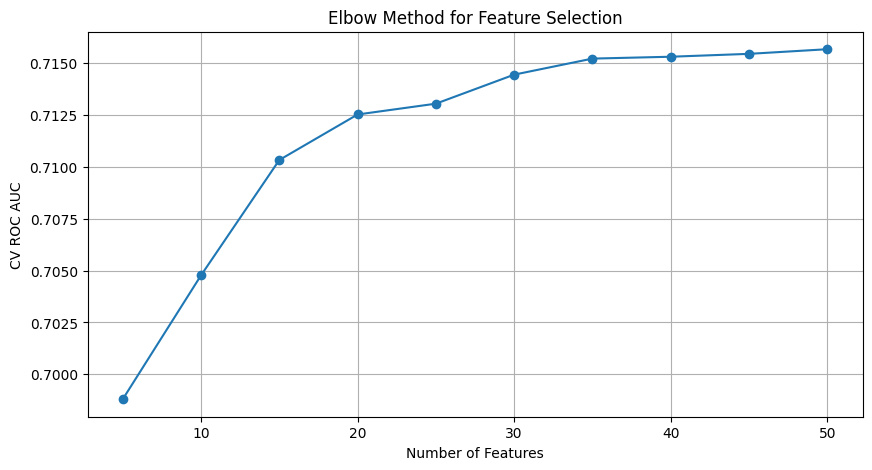

In [ ]:
ks, aucs = zip(*scores)
plt.figure(figsize=(10, 5))
plt.plot(ks, aucs, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("CV ROC AUC")
plt.title("Elbow Method for Feature Selection")
plt.grid(True)
plt.show()

# optimal k seems to be about 35 

In [52]:
k_optimal = 35 # Set based on the above plot  
top_k_features = [final_features[i] for i in sorted_idx[:k_optimal]]
X_top_k = X_final[:, sorted_idx[:k_optimal]]

final_rf = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
final_rf.fit(X_top_k, y)

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       min_samples_split=8, n_estimators=243, random_state=42)

In [94]:
# load and isolate features
X_test = pd.read_csv('/Users/khl/Desktop/test.csv', index_col=0)
X_test = X_test.drop(columns=['loan_status', 'is_default', 'title'], errors='ignore')
# how much of the borrower's income the loan amt. represnts 
X_test['loan_to_income'] =  X_test['loan_amnt'] / X_test['annual_inc']

job_transformer = JobTitleTransformer(
    job_map=JOB_MAP, n_common_titles=30, similarity_threshold=0.6
)
X_test = job_transformer.fit_transform(X_test)
X_test = AddressTransformer().fit_transform(X_test)

Binning job titles: 100%|██████████| 79060/79060 [00:00<00:00, 133343.01it/s]


In [ ]:
# Make a copy
X_test = X_test.copy()

# Fix 'term' formatting
if 'term' in X_test.columns:
    X_test['term'] = X_test['term'].str.extract(r'(\d+)').astype(float)

# Drop any extra columns not used in training
X_test = X_test.drop(columns=['loan_status', 'is_default', 'title'], errors='ignore')

# Handle inf/-inf
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Drop fully null or constant columns
X_test = X_test.dropna(axis=1, how='all')
X_test = X_test.loc[:, X_test.nunique() > 1]

# Apply the same custom transformers
for transformer in [ordinal, purpose, categorical]:
    X_test = transformer.transform(X_test)  # use .transform(), NOT .fit_transform()

# Use the same preprocessor (already fitted)
X_test_processed = preprocessor.transform(X_test)

# Now X_test_processed is ready to be used in the model

In [121]:
# Threshold testing with custom cutoffs
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for t in thresholds:
    y_pred_custom = (submission_df["prediction_proba"] >= t).astype(int)
    num_defaults = y_pred_custom.sum()
    pct_defaults = 100 * num_defaults / len(y_pred_custom)
    
    print(f"📊 Threshold {t:.2f}: {num_defaults} predicted defaults ({pct_defaults:.2f}%)")


📊 Threshold 0.30: 61120 predicted defaults (77.31%)
📊 Threshold 0.40: 44987 predicted defaults (56.90%)
📊 Threshold 0.50: 28981 predicted defaults (36.66%)
📊 Threshold 0.60: 14495 predicted defaults (18.33%)
📊 Threshold 0.70: 4516 predicted defaults (5.71%)


In [122]:
# Based on the top 35 features 
X_test_final = X_test_processed[:, sorted_idx[:k_optimal]]

# Predict probabilities and class labels
y_pred_proba = final_rf.predict_proba(X_test_final)[:, 1]
y_pred_label = (y_pred_proba >= 0.6).astype(int) # threshold raised from the original value of 0.5 to 0.6.

# Prepare output DataFrame
submission_df = pd.DataFrame({
    "prediction_proba": y_pred_proba,
    "prediction_label": y_pred_label
}, index=X_test.index)

# Save to CSV or return as needed
submission_df.to_csv("submission.csv", index=True)
print("✅ Predictions saved to 'submission.csv'")

✅ Predictions saved to 'submission.csv'


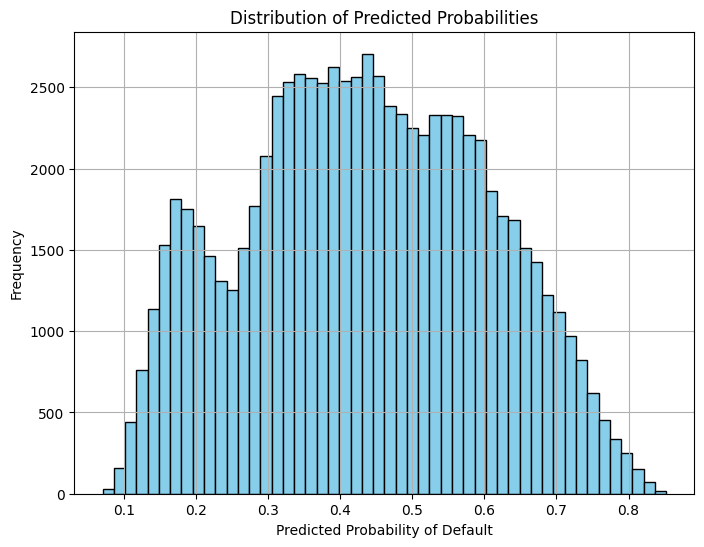

In [ ]:
# model generating well-distributed predicted probabilities of default 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(y_pred_proba, bins=50, color='skyblue', edgecolor='k')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

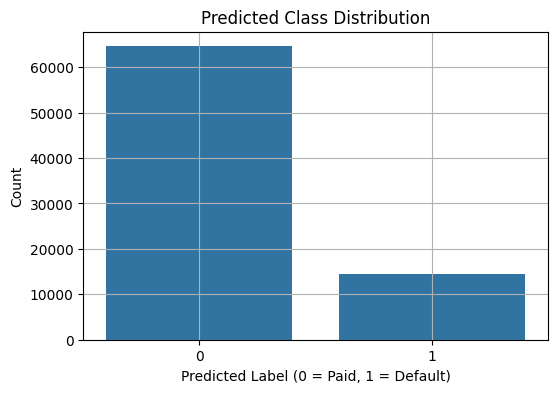

In [124]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred_label)
plt.title("Predicted Class Distribution")
plt.xlabel("Predicted Label (0 = Paid, 1 = Default)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [125]:
# Which ones are most likley to default? 
top_risk = submission_df.sort_values(by="prediction_proba", ascending=False).head(10)
print("🔍 Top 10 High-Risk Predictions:")
print(top_risk)

🔍 Top 10 High-Risk Predictions:
       prediction_proba  prediction_label
10803          0.852245                 1
70012          0.849215                 1
45278          0.841904                 1
40886          0.840626                 1
38227          0.840487                 1
37208          0.840016                 1
47485          0.839766                 1
59020          0.839599                 1
68731          0.839178                 1
3328           0.838640                 1


In [127]:
X_test_top_risk = X_test.loc[top_risk.index]
pd.concat([X_test_top_risk, top_risk], axis=1).to_csv("tp_high_risk_loans.csv")

In [126]:
print(f"🔢 Total loans predicted as default: {(y_pred_label == 1).sum()} out of {len(y_pred_label)}")
print(f"📊 % default predicted: {100 * (y_pred_label == 1).mean():.2f}%")

🔢 Total loans predicted as default: 14495 out of 79060
📊 % default predicted: 18.33%
